# **LSTM - Previsão de preços de ações**

## **Configurações da biblioteca pandas_datareader**

In [ ]:
! pip install --upgrade numpy
! pip install --upgrade pandas
! pip install --upgrade pandas-datareader

## **Obtenção dos dados**

In [ ]:
import pandas_datareader as dados
import pandas as pd

ativo = "AAPL"  # https://finance.yahoo.com/

dados_do_ativo = dados.DataReader(ativo, start="2015-01-01",end="2021-08-24", data_source='yahoo')

dados_do_ativo

## **Visualização dos dados**

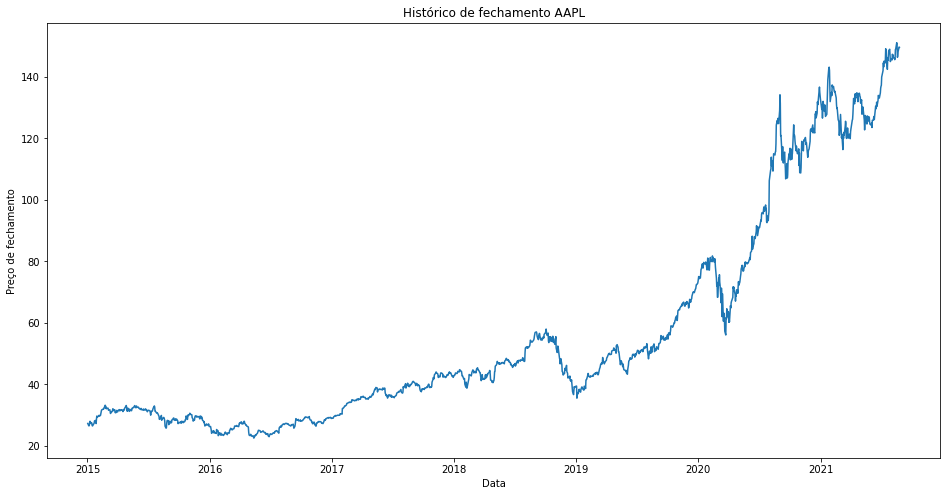

In [10]:
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
# plt.style.use('default')

plt.figure(figsize=(16,8))
plt.title('Histórico de fechamento ' + ativo)
plt.plot(dados_do_ativo['Close'])
plt.xlabel('Data')
plt.ylabel('Preço de fechamento')
plt.show()

### **Preparação dos dados**

In [11]:
cotacoes_df = dados_do_ativo.filter(['Close'])
cotacoes = cotacoes_df.values

from sklearn.preprocessing import MinMaxScaler

normalizador = MinMaxScaler(feature_range=(0, 1)) 
cotacoes_normalizadas = normalizador.fit_transform(cotacoes)

## **Separação dos dados para treinamento**

In [12]:
from math import ceil

dias_treinamento = ceil( len(cotacoes) *.8) 
cotacoes_treinamento = cotacoes_normalizadas[0:dias_treinamento]

x_treino=[]
y_treino = []

for i in range(30,len(cotacoes_treinamento)):
    x_treino.append(cotacoes_treinamento[i-30:i])
    y_treino.append(cotacoes_treinamento[i])


import numpy as np

x_treino, y_treino = np.array(x_treino), np.array(y_treino)

x_treino = np.reshape(x_treino, (len(x_treino),30,1))


## **Criação do modelo**

In [13]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()

model.add(LSTM(units=50, return_sequences=True,input_shape=(30,1)))
model.add(LSTM(units=50, return_sequences=False))

model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

## **Treinamento do modelo**

In [14]:
model.fit(x_treino, y_treino, batch_size=1, epochs=5)

Epoch 1/5
1309/1309 [==============================] - 39s 27ms/step - loss: 5.1378e-04
Epoch 2/5
1309/1309 [==============================] - 21s 16ms/step - loss: 2.1978e-04
Epoch 3/5
1309/1309 [==============================] - 21s 16ms/step - loss: 2.2455e-04
Epoch 4/5
1309/1309 [==============================] - 21s 16ms/step - loss: 1.8164e-04
Epoch 5/5
1309/1309 [==============================] - 22s 16ms/step - loss: 1.4399e-04


## **Separação e preparação dos dados para o teste**

In [15]:
cotacoes_teste = cotacoes_normalizadas[dias_treinamento - 30:]

x_teste = []
y_teste =  cotacoes[dias_treinamento:] 
for i in range(30,len(cotacoes_teste)):
    x_teste.append(cotacoes_teste[i-30:i])


x_teste = np.array(x_teste)
x_teste = np.reshape(x_teste, (len(x_teste),30,1))

## **Teste (predição)**

In [16]:
predictions = model.predict(x_teste) 

predictions = normalizador.inverse_transform(predictions)

## **Cálculo do erro (diferença entre predição e valor real)**

In [17]:
rmse=np.sqrt(np.mean(((predictions- y_teste)**2)))
print(rmse)

2.4544566566738784


## **Gráfico de comparação**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


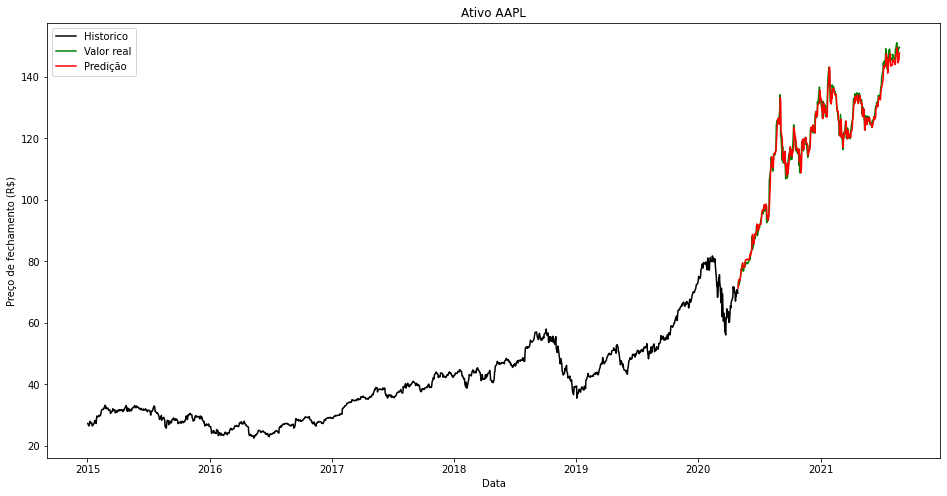

In [18]:
treino = cotacoes_df[:dias_treinamento]
valido = cotacoes_df[dias_treinamento:]
valido['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Ativo ' + ativo)
plt.xlabel('Data')
plt.ylabel('Preço de fechamento (R$)')
plt.plot(treino['Close'], color = 'black')
plt.plot(valido['Close'], color = 'green')
plt.plot(valido['Predictions'], color = 'red')
plt.legend(['Historico', 'Valor real', 'Predição'])
plt.show()

## **Teste atual**

In [19]:

dados_do_ativo = dados.DataReader(ativo, start="2021-08-23",end="2021-10-05", data_source='yahoo')

x = dados_do_ativo.filter(['Close'])
x = normalizador.fit_transform(x)
x = np.array(x)[:-1] # remover o dia 05/10
x = np.reshape(x, (1,30,1))

prediction = model.predict(x) 

prediction = normalizador.inverse_transform(prediction)
real = dados_do_ativo.filter(['Close']).values[-1]

print('pedição: ',prediction)
print('real: ',real)
dados_do_ativo

pedição:  [[140.70226]]
real:  [141.11000061]


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-08-23,150.190002,147.889999,148.309998,149.710007,60131800,149.710007
2021-08-24,150.860001,149.149994,149.449997,149.619995,48606400,149.619995
2021-08-25,150.320007,147.800003,149.809998,148.360001,58991300,148.360001
2021-08-26,149.119995,147.509995,148.350006,147.539993,48597200,147.539993
2021-08-27,148.750000,146.830002,147.479996,148.600006,55721500,148.600006
2021-08-30,153.490005,148.610001,149.000000,153.119995,90956700,153.119995
2021-08-31,152.800003,151.289993,152.660004,151.830002,86453100,151.830002
2021-09-01,154.979996,152.339996,152.830002,152.509995,80313700,152.509995
2021-09-02,154.720001,152.399994,153.869995,153.649994,71115500,153.649994
